In [1]:
import numpy as np

from astropy import units as u
from astropy import cosmology
from astropy import constants as cnst

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt

In [3]:
cosmo = cosmology.default_cosmology.get()
cosmo

FlatLambdaCDM(name="WMAP9", H0=69.3 km / (Mpc s), Om0=0.286, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=0.0463)

### Function to compute escape velocity given halo parameters 

In [4]:
def NFW_escape_vel(r, Mvir, Rvir, CvirorRs, truncated=False):
    """
    NFW profile escape velocity

    Parameters
    ----------
    r : Quantity w/ length units
        Radial distance at which to compute the escape velocity
    Mvir : Quantity w/ mass units
        Virial Mass
    CvirorRs : Quantity w/ dimensionless or distance units
        (Virial) Concentration parameter (if dimensionless), 
        or halo scale radius (if length units)
    Rvir : Quantity w/ length units
        Virial radius
    truncated : bool or float
        False for infinite-size NFW or a number to cut off the 
        halo  at this many times Rvir
    """
    CvirorRs = u.Quantity(CvirorRs)
    if CvirorRs.unit.is_equivalent(u.m):
        Cvir = Rvir/CvirorRs
    elif CvirorRs.unit.is_equivalent(u.one):
        Cvir = CvirorRs
    else:
        raise TypeError('CvirorRs must be length or dimensionless')
        
    a = Rvir / Cvir
    
    #"f-function" from the NFW literature (e.g. klypin 02) evaluated at Cvir
    fofC = np.log(1 + Cvir) - Cvir / (1 + Cvir)
    
    # value of the NFW potential at that point
    potential = (-cnst.G * Mvir / fofC) * np.log(1 + (r / a)) / r

    if truncated:
        rtrunc = Rvir * float(truncated)
        Ctrunc = rtrunc / a

        mtrunc = Mvir * (np.log(1 + Ctrunc) - Ctrunc / (1 + Ctrunc)) / fofC

        outer = r >= rtrunc
        potential[outer] = - Gkpc * mtrunc / r[outer]
        potential[~outer] = potential[~outer] + (Gkpc * Mvir / a) / (Ctrunc + 1) / fofC

    vesc = (2 * np.abs(potential)) ** 0.5
    return vesc.to(u.km/u.s)

### Functions to compute halo parameters given cosmology and Mvir 

In [5]:
def Deltavir(cosmo, z=0):
    """
    Standard Delta-vir from Bryan&Norman 98 (*not* Delta-c)
    """
    x = cosmo.Om(z) - 1
    return (18*np.pi**2 + 82*x - 39*x**2)/(x+1)

Use these basic relations to get rvir<->mir conversion:

$\bar{\rho}_{\rm halo} = \Delta_{\rm vir}\Omega_m \rho_c$

$\frac{3 M_{\rm vir}}{4 \pi r^3_{\rm vir}} =\Delta_{\rm vir}(z) \Omega_m(z) \frac{3 H^2(z)}{8 \pi G}$

In [6]:
def rvirmvir(rvirormvir, cosmo, z=0):
    """
    Convert between Rvir and Mvir
    
    Parameters
    ----------
    rvirormvir : Quantity w/ mass or length units
        Either Rvir or Mvir, depending on the input units
    cosmo : astropy cosmology
        The cosmology to assume
    z : float
        The redshift to assume for the conversion
        
    Returns
    -------
    mvirorrvir : Quantity w/ mass or length units
         Whichever ``rvirormvir`` is *not*
    """
    rhs = Deltavir(cosmo=cosmo, z=z) * cosmo.Om(z)*cosmo.H(z)**2 / (2*cnst.G)
    
    if rvirormvir.unit.is_equivalent(u.solMass):
        mvir = rvirormvir
        return ((mvir / rhs)**(1/3)).to(u.kpc)
    elif rvirormvir.unit.is_equivalent(u.kpc):
        rvir = rvirormvir
        return (rhs * rvir**3).to(u.solMass)
    else:
        raise ValueError('invalid input unit {}'.format(rvirormvir))

In [7]:
def mvir_to_cvir(mvir, z=0):
    """ Power-law fit to the c_vir-M_vir relation from
    Equations 12 & 13 of Dutton & Maccio 2014, arXiv:1402.7073.
    """
    a = 0.537 + (1.025 - 0.537) * np.exp(-0.718 * z**1.08)
    b = -0.097 + 0.024 * z
    m0 = 1e12 * u.solMass

    logc = a + b * np.log10(mvir / m0)
    return 10**logc

###  A function to put all that together and use just Mvir

In [8]:
def NFW_escape_vel_from_Mvir(r, Mvir, z=0,
                             cosmo=cosmology.Planck15,
                             truncated=False):
    cvir = mvir_to_cvir(Mvir, z)
    rvir = rvirmvir(Mvir, cosmo, z)
    return NFW_escape_vel(r, Mvir=Mvir, 
                          CvirorRs=cvir, 
                          Rvir=rvir, 
                          truncated=truncated)

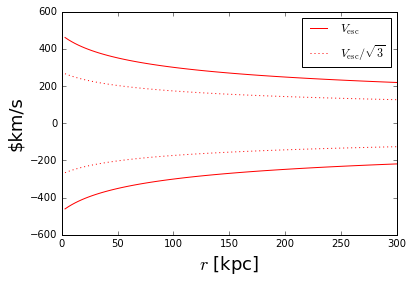

In [9]:
r = np.linspace(0, 300,101)[1:]*u.kpc #0 has a singularity

vesc = NFW_escape_vel_from_Mvir(r, 1e12*u.solMass)

plt.plot(r, vesc, c='r', label=r'$V_{\rm esc}$')
plt.plot(r, -vesc, c='r')

plt.plot(r, 3**-0.5*vesc, c='r', ls=':', label=r'$V_{\rm esc}/\sqrt{3}$')
plt.plot(r, -3**-0.5*vesc, c='r', ls=':')

plt.legend(loc=0)
plt.xlabel('$r$ [kpc]', fontsize=18)
plt.ylabel(r'$km/s', fontsize=18)

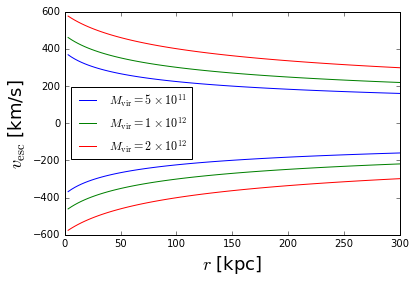

In [10]:
r = np.linspace(0, 300,101)[1:]*u.kpc #0 has a singularity

vesc0p5 = NFW_escape_vel_from_Mvir(r, 5e11*u.solMass)
vesc1 = NFW_escape_vel_from_Mvir(r, 1e12*u.solMass)
vesc2 = NFW_escape_vel_from_Mvir(r, 2e12*u.solMass)

plt.plot(r, vesc0p5, c='b', label=r'$M_{\rm vir}=5 \times 10^{11}$')
plt.plot(r, -vesc0p5, c='b')

plt.plot(r, vesc1, c='g', label=r'$M_{\rm vir}=1 \times 10^{12}$')
plt.plot(r, -vesc1, c='g')

plt.plot(r, vesc2, c='r', label=r'$M_{\rm vir}=2 \times 10^{12}$')
plt.plot(r, -vesc2, c='r')

plt.legend(loc=0)
plt.xlabel('$r$ [kpc]', fontsize=18)
plt.ylabel(r'$v_{\rm esc}$ [km/s]', fontsize=18)